In [1]:
import sys
sys.path.insert(0, '../..')

In [2]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook

from causal_meta.utils.data_utils import generate_data_categorical
from models import StructuralModel

In [3]:
N = 10
model = StructuralModel(N, dtype=torch.float64)

In [4]:
num_episodes = 500
batch_size = 100 # 1
num_test = 10000
num_training = 10 # 100
num_transfers = 10 # 100

In [5]:
optimizer = torch.optim.SGD(model.modules_parameters(), lr=1.)

In [6]:
losses = np.zeros((2, num_training, num_transfers, num_episodes))

for k in tnrange(num_training):
    pi_A_1 = np.random.dirichlet(np.ones(N))
    pi_B_A = np.random.dirichlet(np.ones(N), size=N)
    for j in tnrange(num_transfers, leave=False):
        model.set_ground_truth(pi_A_1, pi_B_A)
        pi_A_2 = np.random.dirichlet(np.ones(N))
        x_val = torch.from_numpy(generate_data_categorical(num_test, pi_A_2, pi_B_A))
        
        for i in range(num_episodes):
            x_transfer = torch.from_numpy(generate_data_categorical(batch_size, pi_A_2, pi_B_A))
            
            model.zero_grad()
            loss_A_B = -torch.mean(model.model_A_B(x_transfer))
            loss_B_A = -torch.mean(model.model_B_A(x_transfer))
            loss = loss_A_B + loss_B_A
            
            with torch.no_grad():
                val_loss_A_B = -torch.mean(model.model_A_B(x_val))
                val_loss_B_A = -torch.mean(model.model_B_A(x_val))

            losses[:, k, j, i] = [val_loss_A_B.item(), val_loss_B_A.item()]

            loss.backward()
            optimizer.step()

/Users/dansuh/cover-song-detection-prototype/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/dansuh/cover-song-detection-prototype/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


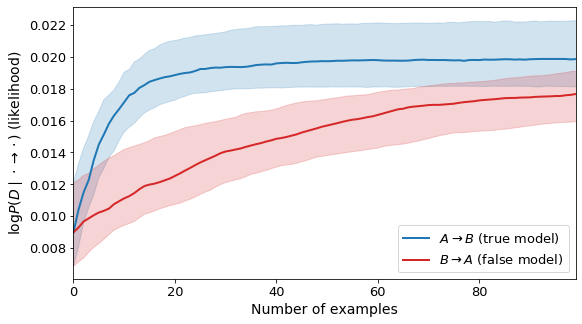

In [11]:
flat_losses = -losses.reshape((2, -1, num_episodes))
flat_losses = np.exp(flat_losses)
losses_25, losses_50, losses_75 = np.percentile(flat_losses, (25, 50, 75), axis=1)

plt.figure(figsize=(9, 5))

ax = plt.subplot(1, 1, 1)
ax.plot(losses_50[0], color='C0', label=r'$A \rightarrow B$ (true model)', lw=2)
ax.fill_between(np.arange(num_episodes), losses_25[0], losses_75[0], color='C0', alpha=0.2)
ax.plot(losses_50[1], color='C3', label=r'$B \rightarrow A$ (false model)', lw=2)
ax.fill_between(np.arange(num_episodes), losses_25[1], losses_75[1], color='C3', alpha=0.2)
ax.set_xlim([0, flat_losses.shape[1] - 1])
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc=4, prop={'size': 13})
ax.set_xlabel('Number of examples', fontsize=14)
ax.set_ylabel(r'$\log P(D\mid \cdot \rightarrow \cdot)$ (likelihood)', fontsize=14)

plt.show()